# VariTex Demo
This notebook is about [Varitex: Variational Neural Face Textures](https://arxiv.org/pdf/2104.05988.pdf) ([ICCV 2021](https://iccv2021.thecvf.com/)). For more information, please visit the [project page](https://mcbuehler.github.io/VariTex/).

![](https://ait.ethz.ch/people/buehler/public/varitex/teaser.png)

## Preparation
Please follow the instructions in the [README](https://github.com/mcbuehler/VariTex/blob/main/README.md) and download the following files:
- [ ] the model [checkpoint](https://ait.ethz.ch/people/buehler/public/varitex/pretrained.zip)
- [ ] the preprocessed [dataset](https://ait.ethz.ch/people/buehler/public/varitex/dataset_preprocessed.zip)
- [ ] the [Basel Face Model](https://faces.dmi.unibas.ch/bfm/bfm2017.html)
- [ ] the Basel Face Model [UV parameterization](https://github.com/unibas-gravis/parametric-face-image-generator/blob/master/data/regions/face12.json). 



In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import pytorch_lightning as pl
import torch
import numpy as np
from varitex.data.keys_enum import DataItemKey as DIK
pl.seed_everything(1234)
from mutil.object_dict import ObjectDict
from torch.nn.functional import normalize as normalizeT



Global seed set to 1234


In [4]:
import sys
sys.path.append('/home/matthias/ETH/Thesis/nFlows/nflows')
#### Nflows
from nflows.flows.base import Flow
from nflows.flows.realnvp import SimpleRealNVP
from nflows.distributions.normal import StandardNormal
from nflows.transforms.coupling import CouplingTransform, AffineCouplingTransform, AdditiveCouplingTransform
from nflows.flows import realnvp
sys.path.append('/home/matthias/ETH/Thesis/nFlows/pytorch-normalizing-flows/')

#### NfLib
# from nflib.flows import (
#     AffineConstantFlow, ActNorm, AffineHalfFlow, 
#     SlowMAF, MAF, IAF, Invertible1x1Conv,
#     NormalizingFlow, NormalizingFlowModel,
# )
# from nflib.spline_flows import NSF_AR, NSF_CL




from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
import itertools

from nflows.flows.base import Flow
from nflows.flows.realnvp import SimpleRealNVP
from nflows.flows.autoregressive import MaskedAutoregressiveFlow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedUMNNAutoregressiveTransform, MaskedPiecewiseLinearAutoregressiveTransform,MaskedPiecewiseQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation, RandomPermutation
from nflows.transforms.nonlinearities import LeakyReLU
from nflows.transforms.normalization import ActNorm, BatchNorm
from nflows.transforms.coupling import CouplingTransform, AffineCouplingTransform, AdditiveCouplingTransform
from nflows.transforms.standard import PointwiseAffineTransform

import matplotlib.pyplot as plt

In [5]:
Res128_nonorm_path = '/home/matthias/ETH/Thesis/VariTexLocal/VariTex/output/varitex/varitex/Res128_GLO_nonorm/checkpoints/epoch=43-step=377079.ckpt'

ckptFolder ='/home/matthias/ETH/Thesis/VariTexLocal/output/ckpts/Res128_GLO_NoNorm'
filename = 'epoch=43-step=377079.ckpt'
Res128_nonorm_path = os.path.join(ckptFolder, filename)
Res128_norm1_path = '/home/matthias/ETH/Thesis/VariTexLocal/output/forDemo/1vc1xbec/checkpoints/epoch=43-step=377079.ckpt'
nfFolderPath = '/home/matthias/ETH/Thesis/nFlows/nflows'
nfCKPT = 'young-sun-6.ckpt'
nfPath = os.path.join(nfFolderPath,nfCKPT)
opt = {

        #"checkpoint": os.path.join(os.getenv("CP", "pretrained/ep44.ckpt")),
        "checkpoint": Res128_nonorm_path,
        "dataroot_npy": os.path.join(os.getenv("DP", ""), 'FFHQ/preprocessed_dataset_new'),
        "path_bfm": os.path.join(os.getenv("FP", ""), "basel_facemodel/model2017-1_face12_nomouth.h5"),
        "path_uv": os.path.join(os.getenv("FP", ""), "basel_facemodel/face12.json"),
        "device": "cuda"
        }

path_latent = os.path.join(os.getenv("DP"), "FFHQ/preprocessed_dataset_new/latents.npy")

from varitex.demo import Demo
demo = Demo(opt)

Loading BFM 2017 into GPU... (this can take a while)
Done


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /home/matthias/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

### Loading Latent Distributions
The variables `latent_mean` and `latent_std` contain the mean and standard deviations of all samples from the holdout set, predicted by the encoder. You can choose the index of the distribution that you want to render, or you can sample from these distributions.


Example indices from the holdout set used the [paper](https://arxiv.org/pdf/2104.05988.pdf):
* [Teaser image](https://ait.ethz.ch/people/buehler/public/varitex/teaser.png) (Fig. 1): 184 (female), 33 (male).
* Fig. 3: 8 (Identity 1), 904 (identity 2).
* Fig. 5: Sampled from distributions 184, 148, 313, 319.

latent_distributions = np.load(path_latent)
latent_mean = torch.Tensor(latent_distributions[:,0])
latent_std = torch.Tensor(latent_distributions[:,1])
print("{} distributions loaded.".format(latent_mean.shape[0]))

# VariTex Controls

![](https://ait.ethz.ch/people/buehler/public/varitex/varitex_pipeline_inference.png)

The generator $G$ provides
    a) __neural control__ over identity and appearance via a latent code `z` (consisting of two parts $z_{face}$ and $z_{additive}$) and 
    b) __graphical control__ over geometry (shape `sp`, expression `ep`, and pose `R`) via the parameters of a 3D morphable face model. For simplicity, let's define the pose as euler angles `theta` ($\theta$).
    
$$G (z, sp, ep, R(\theta))$$

* `z` $\in \mathbb{R}^{256}$: Latent identity code.
* `sp` $\in \mathbb{R}^{199}$ and `ep` $\in \mathbb{R}^{100}$: Shape and expression coefficients of the Basel Face Model. They define the geometry of the rendered face. Zeros yield a neutral face.
* `theta` $\in \mathbb{R}^3$: Pose in euler angles (degrees). Zeros yield a frontal face.

## Graphical Control: Pose and Expression

### Shape and Expression
We load shape `sp` and expression `ep` coefficients from the FFHQ validation set. Choose any other index to load different shapes and expressions from the validation set. These parameters could also be sampled from the Basel Face Model.

Change the indices for `sp` and `ep` to modify the facial expression, and shape.

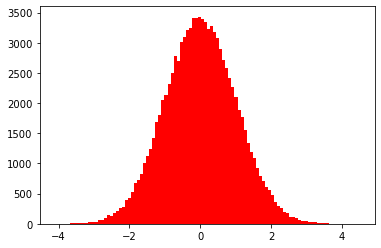

In [114]:


plt.hist(stdNormal,bins = 100,color='r')
plt.show()

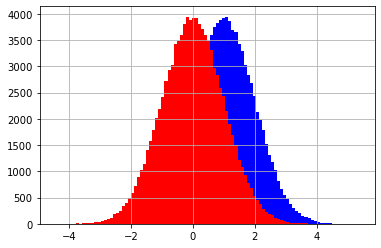

In [121]:
standard = torch.randn(100000).numpy().flatten()
mu=1.
sigma=1.0
normal = torch.normal(mu,sigma,size = [100000]).numpy().flatten()
plt.hist([standard, normal],bins = 100,color=['r','b'], histtype='stepfilled')
plt.grid()
plt.show()

# Random sampling

## Linear

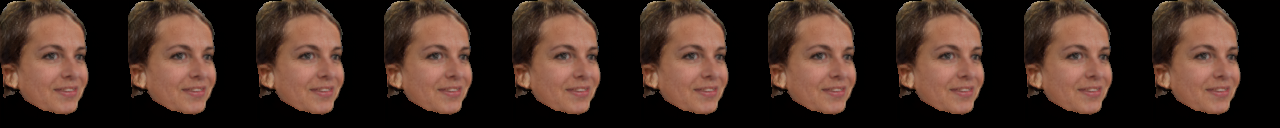

In [6]:
shapes, expressions = demo.load_shape_expressions()
index_id, index_sp, index_ep = 184, 184, 184
sp = shapes[index_sp].unsqueeze(0)
ep = expressions[index_ep].unsqueeze(0)
theta = torch.Tensor((0,-35,0))
z_sampled = (normalizeT(torch.randn(10, 256),dim=1)*1)


norm = 0
batches_out = [demo.runGlo(z=z.unsqueeze(0)*norm, sp=sp, ep=ep, theta=theta) for z in z_sampled]
demo.to_image(batches_out)

## Spherical

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


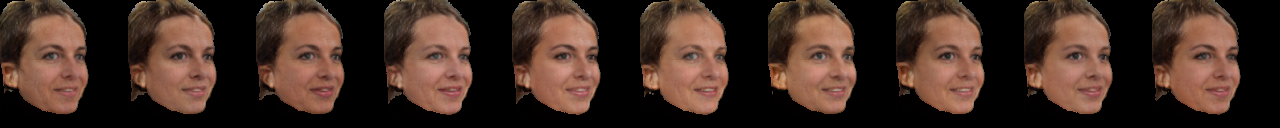

In [7]:
norm = 1
batches_out = [demo.runGlo(z=z.unsqueeze(0)*norm, sp=sp, ep=ep, theta=theta) for z in z_sampled]
print(torch.linalg.norm(z_sampled, dim=1))
demo.to_image(batches_out)

tensor([2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000])


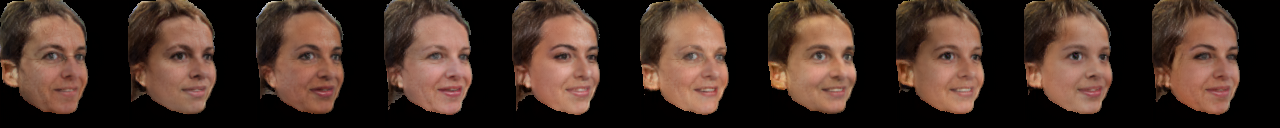

In [8]:
norm = 2
batches_out = [demo.runGlo(z=z.unsqueeze(0)*norm, sp=sp, ep=ep, theta=theta) for z in z_sampled]
print(torch.linalg.norm(z_sampled*norm, dim=1))
demo.to_image(batches_out)

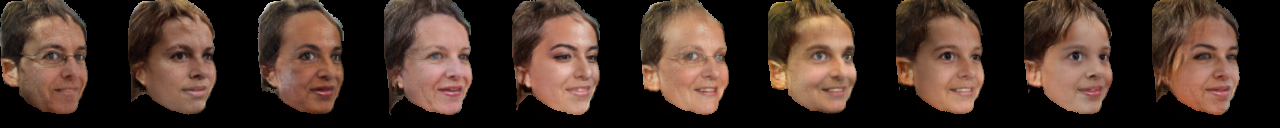

In [9]:
norm = 3
batches_out = [demo.runGlo(z=z.unsqueeze(0)*norm, sp=sp, ep=ep, theta=theta) for z in z_sampled]
demo.to_image(batches_out)

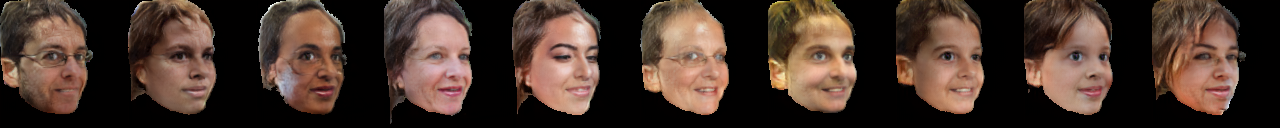

In [10]:
norm = 4
batches_out = [demo.runGlo(z=z.unsqueeze(0)*norm, sp=sp, ep=ep, theta=theta) for z in z_sampled]
demo.to_image(batches_out)

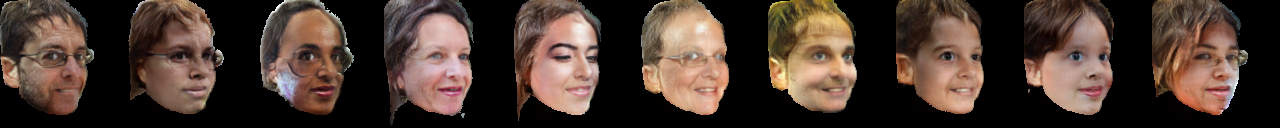

In [11]:
norm = 5
batches_out = [demo.runGlo(z=z.unsqueeze(0)*norm, sp=sp, ep=ep, theta=theta) for z in z_sampled]
demo.to_image(batches_out)

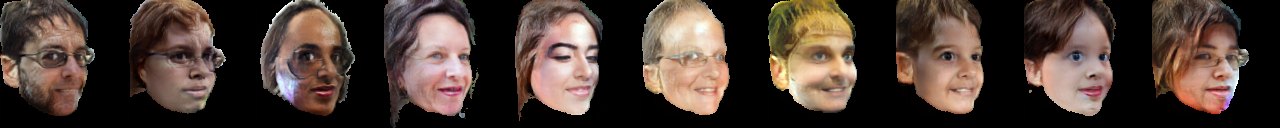

In [12]:
norm = 6
batches_out = [demo.runGlo(z=z.unsqueeze(0)*6, sp=sp, ep=ep, theta=theta) for z in z_sampled]
demo.to_image(batches_out)

# Random interpolation

Norms:  tensor([3.0000, 2.6222, 2.2593, 2.0412, 2.1015, 2.3779, 2.6747, 2.8769, 2.9749,
        3.0000])


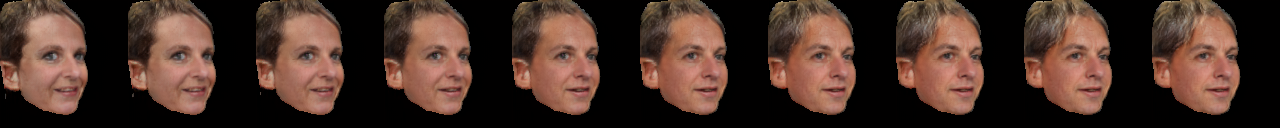

In [13]:
from mutil.np_util import interpolation
n_samples = 10

norm = 3
zA, zB = (normalizeT(torch.randn(256),dim=0)*norm), (normalizeT(torch.randn(256),dim=0)*norm) 
z_interpolated = torch.Tensor(interpolation(n_samples, zA.numpy(), zB.numpy()))
batches_out = [demo.runGlo(z=z.unsqueeze(0), sp=sp, ep=ep, theta=theta) for z in z_interpolated]
print("Norms: ", torch.linalg.norm(z_interpolated, dim=1))
demo.to_image(batches_out)

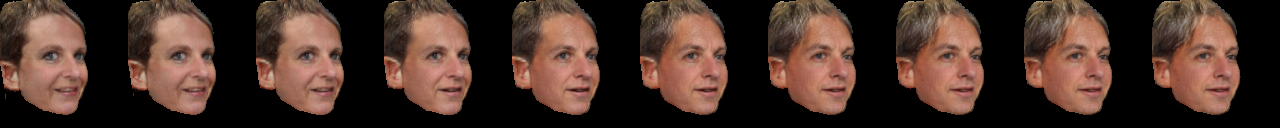

In [14]:
batches_out = [demo.runGlo(z=normalizeT(z, dim=0).unsqueeze(0)*norm, sp=sp, ep=ep, theta=theta) for z in z_interpolated]
demo.to_image(batches_out)

# Zero to norm n interpolation

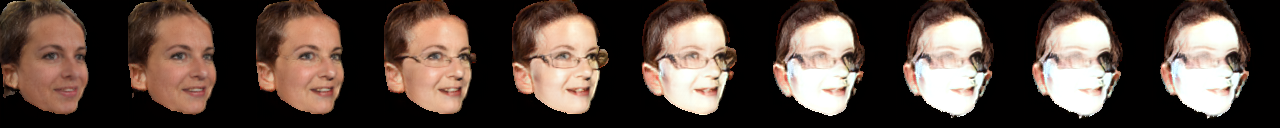

In [15]:
n_samples = 10

norm = 11
zA, zB = (torch.zeros(256).unsqueeze(0)), (normalizeT(torch.randn(256),dim=0).unsqueeze(0)*norm) 
z_interpolated = torch.Tensor(interpolation(n_samples, zA.numpy(), zB.numpy()))
batches_out = [demo.runGlo(z=z, sp=sp, ep=ep, theta=theta) for z in z_interpolated]
demo.to_image(batches_out)

Norms:  tensor([3.0237, 3.5769, 3.5593, 3.7999, 4.3907, 3.0997, 3.2124, 3.8808, 3.3501,
        3.5442], device='cuda:0', grad_fn=<CopyBackwards>)


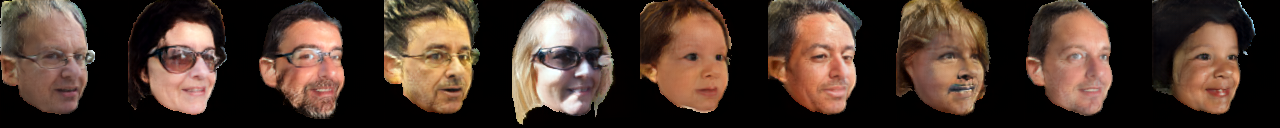

In [16]:
latent = demo.pipeline.Z.weight
latent = latent[:59990]
latent_training_codes = latent[21:31]
batches_out = [demo.runGlo(z=z.unsqueeze(0), sp=sp, ep=ep, theta=theta) for z in latent_training_codes]
print("Norms: ", torch.linalg.norm(latent_training_codes,dim=1))
demo.to_image(batches_out)

Norms:  tensor([2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000,
        2.5000], device='cuda:0', grad_fn=<CopyBackwards>)


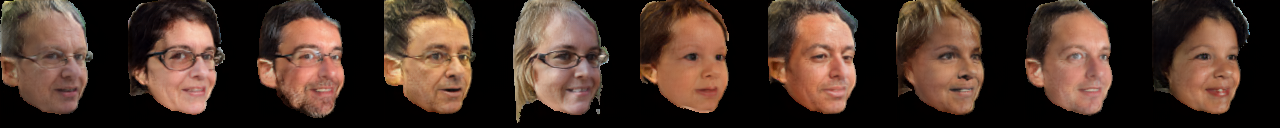

In [17]:
latent_training_codes = normalizeT(latent_training_codes, dim=1)*2.5
batches_out = [demo.runGlo(z=z.unsqueeze(0), sp=sp, ep=ep, theta=theta) for z in latent_training_codes]
print("Norms: ", torch.linalg.norm(latent_training_codes,dim=1))
demo.to_image(batches_out)

In [18]:
import matplotlib.pyplot as plt
def show_hist_full(i):
    HIST_BINS = np.linspace(-1.5, 1.5, 100)
    plt.hist(latent.detach().cpu().numpy().flatten(), HIST_BINS,alpha=1)
    filename = os.path.join('output/hists/full','hist_full_epoch')
    #plt.savefig(filename+str(i)+'full.jpg')
    plt.show()
    
def show_hist(i):
    HIST_BINS = np.linspace(-1.5, 1.5, 100)
    plt.hist(latent[i,:128].detach().cpu().numpy().flatten(), HIST_BINS,alpha=1)
    plt.hist(latent[i,128:].detach().cpu().numpy(), HIST_BINS,alpha=0.6)
    plt.title('Latent code: '+str(i))
    filename = os.path.join('output/hists','hist_epoch')
    plt.savefig(filename+str(i)+'.jpg')
    plt.show()

In [99]:
print(torch.mean(latent,dim=1).mean().item())

0.0001592803018866107


[autoreload of varitex.modules.pipeline failed: Traceback (most recent call last):
  File "/home/matthias/miniconda3/envs/varitex/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/matthias/miniconda3/envs/varitex/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/matthias/miniconda3/envs/varitex/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/matthias/miniconda3/envs/varitex/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootst

In [19]:
latent = torch.load(Res128_nonorm_path)['state_dict']['Z.weight']

# Normalizing Flows (extra)

# Use NflowLib

In [20]:
latent = demo.pipeline.Z.weight
latent = latent[:59990]

In [91]:
def getTransform(transform, config):
    ##Permutations
    if(transform == 'randomPermutation'):
        return RandomPermutation(features=config['num_features'])
    elif(transform == 'reversePermutation'):
        return ReversePermutation(features=config['num_features'])
    ##Autoregressions
    elif(transform == 'maskedAffineAR'):
        return MaskedAffineAutoregressiveTransform(features=config['num_features'],
                                                   hidden_features=config['hidden_features'])
    elif(transform == 'maskedAffineARUMNN'):
        return MaskedUMNNAutoregressiveTransform(features=config['num_features'],
                                                 hidden_features=config['hidden_features'])
    elif(transform == 'maskedAffineARLinear'):
        return MaskedPiecewiseLinearAutoregressiveTransform(features=config['num_features'],
                                                         hidden_features=config['hidden_features'],
                                                        num_bins = 10)
    elif(transform == 'maskedAffineARQuadratic'):
        return MaskedPiecewiseQuadraticAutoregressiveTransform(features=config['num_features'],
                                                        hidden_features=config['hidden_features'],
                                                        num_bins = 10)
    elif(transform == 'actNorm'):
        return ActNorm(features=config['num_features'])
    elif(transform == 'batchNorm'):
        return BatchNorm(features=config['num_features'])
    else:
        print("Transform "+ transform +" is not supported")


def getFlow(config):
    modelName = config['model']
    base_dist = StandardNormal(shape=[config['num_features']])
    if(not isinstance(modelName,list)):
        if(modelName=='simpleRNVP'):
            flow = realnvp.SimpleRealNVP(
                    features = config['num_features'], 
                    hidden_features = config['hidden_features'], 
                    num_layers = config['num_layers'], 
                    num_blocks_per_layer = config['num_blocks_per_layer'],
                    activation = config['activation'],
                    use_volume_preserving = config['use_volume_preserving'],
                    batch_norm_between_layers = config['batch_norm_between_layers'], 
                    batch_norm_within_layers = config['batch_norm_within_layers'],
                    dropout_probability = config['dropout_probability'] )
            return flow
        elif(modelName == 'made'):
            flow = MaskedAutoregressiveFlow(
                    features = config['num_features'], 
                    hidden_features = config['hidden_features'], 
                    num_layers = config['num_layers'], 
                    num_blocks_per_layer = config['num_blocks_per_layer'])
            return flow
    else:
        transforms = []
        for _ in range(config['num_layers']):
            for layer in modelName:
                transforms.append(getTransform(layer,config))     
    transform = CompositeTransform(transforms)
    flow = Flow(transform, base_dist)
    return flow

def getAllFlows(expPath, exp_name, maxEpoch):
    models = []
    for i in range(maxEpoch):
        currentPath = os.path.join(expPath, exp_name+str(i)+'.ckpt')
        currentDicts = torch.load(currentPath)
        config = currentDicts['config']
        model = getFlow(config)
        model.load_state_dict(currentDicts['model_state_dict'])
        models.append(model)
    return models
        
def getBatches(model, nImages=10):
    model.eval()
    shapes, expressions = demo.load_shape_expressions()
    index_id, index_sp, index_ep = 184, 184, 184
    index_id, index_sp, index_ep = 184, 184, 184
    sp = shapes[index_sp].unsqueeze(0)
    ep = expressions[index_ep].unsqueeze(0)
    theta = torch.Tensor((0,-35,0))
    samples = model.sample(nImages)
    samples = samples.detach()
    batches_out = [demo.runGlo(z=z.unsqueeze(0), sp=sp, ep=ep, theta=theta) for z in samples]
    printGParams(samples.numpy(), "current Model")
    return batches_out

Mean current Model: 2.64009158E-03
Std current Model: 2.32148573E-01
Norm current Model: 3.72547221E+00


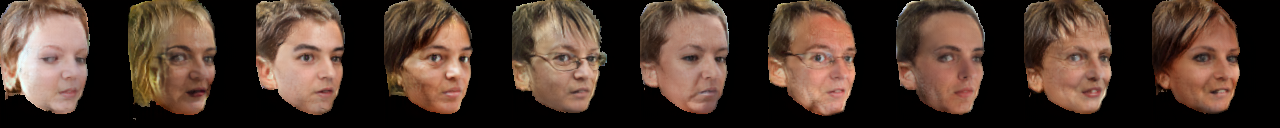

In [92]:
nfFolderPath = '/home/matthias/ETH/Thesis/nFlows/nflows/output'
exp_name = 'blooming-universe-33'
expPath = os.path.join(nfFolderPath,exp_name)
models = getAllFlows(expPath, exp_name, 37)
i=0
batches_out = getBatches(models[i],10)
demo.to_image(batches_out)

Mean current Model: 7.05914851E-03
Std current Model: 2.25307018E-01
Norm current Model: 3.61112165E+00


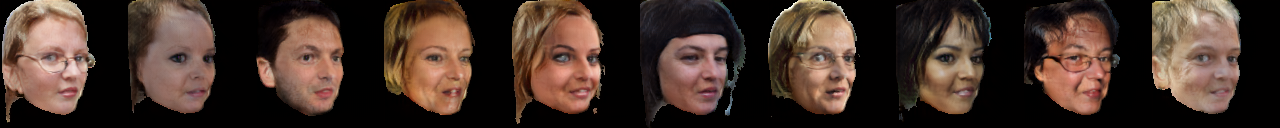

In [93]:
i=10
batches_out = getBatches(models[i],10)
demo.to_image(batches_out)

Mean current Model: -1.67305511E-03
Std current Model: 2.28290632E-01
Norm current Model: 3.66010022E+00


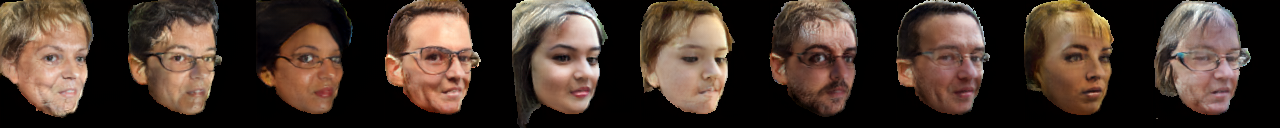

In [94]:
i=20
batches_out = getBatches(models[i],10)
demo.to_image(batches_out)

Mean current Model: -5.19977231E-03
Std current Model: 2.37800837E-01
Norm current Model: 3.81651616E+00


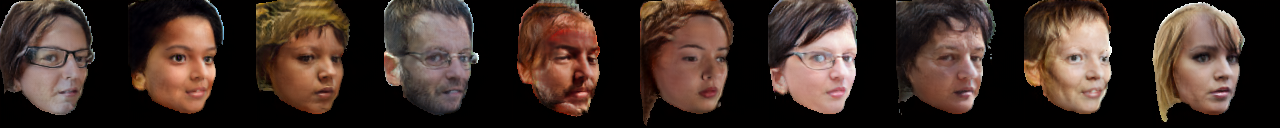

In [95]:
i=30
batches_out = getBatches(models[i],10)
demo.to_image(batches_out)

In [56]:
for i in models:
    makeImages(i)

In [36]:
nfFolderPath = '/home/matthias/ETH/Thesis/nFlows/nflows/output'
exp_name = 'golden-energy-32'
expPath = os.path.join(nfFolderPath,exp_name)
cepoch = 5
nfPath = os.path.join(expPath, exp_name+str(cepoch)+'.ckpt')

In [37]:
flowDicts = torch.load(nfPath)
print(flowDicts.keys())
config = flowDicts['config']
print(config)
flow = getFlow(config)
model = flow
model.load_state_dict(flowDicts['model_state_dict'])
flowDicts['epoch']

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'config'])
{'model': ['reversePermutation', 'maskedAffineAR', 'actNorm'], 'num_features': 256, 'hidden_features': 256, 'num_layers': 2, 'num_blocks_per_layer': 2, 'activation': <function relu at 0x7f06a45f1700>, 'use_volume_preserving': False, 'batch_norm_between_layers': False, 'batch_norm_within_layers': False, 'dropout_probability': 0, 'lr': 0.0001, 'batch_size': 32}


5

In [38]:
def printGParams(l, name):
    print('Mean '+name+':', "{:.8E}".format(l.mean(1).mean().astype('float')))
    print('Std '+name+':', "{:.8E}".format(l.std(1).mean().astype('float')))
    print('Norm '+name+':', "{:.8E}".format(np.linalg.norm(l, axis=1).mean().astype('float')))


In [39]:
printGParams(latent.detach().cpu().numpy(),'x')

Mean x: 1.59280302E-04
Std x: 2.24574611E-01
Norm x: 3.60411024E+00


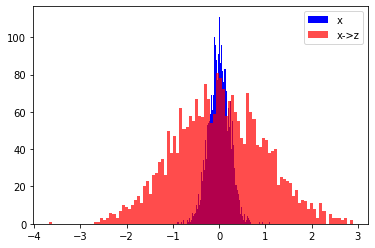

Mean x: 1.06094403E-05
Std x: 2.21906468E-01
Norm x: 3.57291746E+00
Mean z: 3.44955409E-03
Std z: 9.68236744E-01
Norm z: 1.55480175E+01


In [40]:
model.eval()

fold = model.sample(10)
fold = fold.detach().numpy()

exLatent = latent[:10,:256].cpu()
pLatent = model._transform(exLatent)
exLatent = exLatent.detach().numpy()
pLatent = pLatent[0].detach().numpy()

plt.hist(exLatent.flatten(),color='b',bins=100, alpha=1,label='x')
plt.hist(pLatent.flatten(),color='r',bins=100, alpha=0.7,label='x->z')
#plt.hist(fnew,bins=100,alpha=0.5)
plt.legend()
plt.show()
printGParams(exLatent,'x')
printGParams(pLatent,'z')

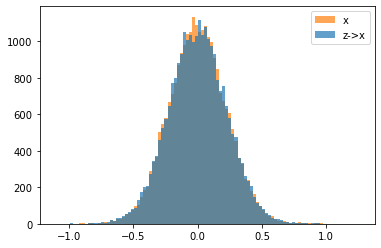

Mean x: 1.41125452E-03
Std x: 2.21892580E-01
Norm x: 3.56522036E+00
Mean x sampled: 3.09475581E-04
Std x sampled: 2.25093082E-01
Norm x sampled: 3.61178827E+00


In [41]:
n = 100
fold = model.sample(n)
fold = fold.detach().numpy()
exLatent = latent[:n,:256].cpu()
exLatent = exLatent.detach().numpy()
#plt.hist(exLatent.flatten(),color='b',bins=100, alpha=1,label='x')
#plt.hist(fold.flatten(),color='r',bins=100, alpha=0.5,label='z->x')
#plt.hist(pLatent.flatten(),color='r',bins=100, alpha=0.7,label='x->z')
plt.hist([fold.flatten(),exLatent.flatten()], bins=100, alpha=0.7,label=['z->x','x'], stacked=False, histtype='stepfilled')
#plt.hist(fnew,bins=100,alpha=0.5)
plt.legend()
plt.show()
printGParams(exLatent,'x')
printGParams(fold,'x sampled')

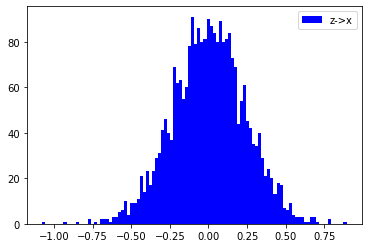

In [42]:
fold = model.sample(10)
fold = fold.detach().numpy()

plt.hist(fold.flatten(),color='b',bins=100, alpha=1,label='z->x')
#plt.hist(pLatent.flatten(),color='r',bins=100, alpha=0.7,label='x->z')
#plt.hist(fnew,bins=100,alpha=0.5)
plt.legend()
plt.show()

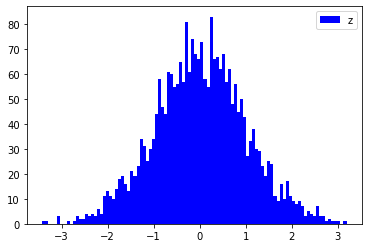

Mean prior: 2.49616094E-02
Std prior: 9.93472278E-01
Norm prior: 1.59170866E+01


In [43]:
fold = model._distribution.sample(10)
fold = fold.detach().numpy()

plt.hist(fold.flatten(),color='b',bins=100, alpha=1,label='z')
#plt.hist(pLatent.flatten(),color='r',bins=100, alpha=0.7,label='x->z')
#plt.hist(fnew,bins=100,alpha=0.5)
plt.legend()
plt.show()
printGParams(fold,'prior')

(100, 256)
Groundtruth tensor(3.5949, device='cuda:0')
NF Latent sampled tensor(3.6265)


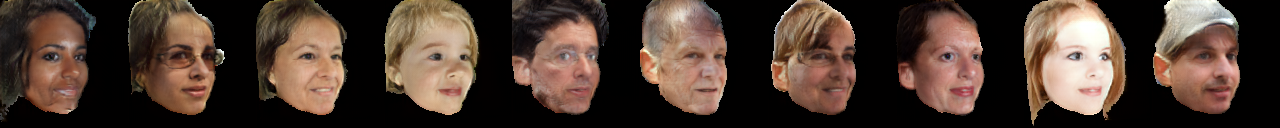

In [44]:
zs = model.sample(100)
z = zs.detach().numpy()
print(z.shape)
z = z.flatten()

shapes, expressions = demo.load_shape_expressions()
index_id, index_sp, index_ep = 184, 184, 184
sp = shapes[index_sp].unsqueeze(0)
ep = expressions[index_ep].unsqueeze(0)
theta = torch.Tensor((0,-35,0))


z_sampled = (normalizeT(torch.randn(10, 256),dim=1)*1)
samples = zs.detach()
# normsSampled.append(torch.norm(samples,dim=1).mean().item())
# normsSampled.append(torch.norm(samples,dim=1).mean().item())
print('Groundtruth',torch.norm(latent[:1000].detach(),dim=1).mean())
print('NF Latent sampled', torch.norm(samples,dim=1).mean())
norm = 0
batches_out = [demo.runGlo(z=z.unsqueeze(0), sp=sp, ep=ep, theta=theta) for z in samples[:10]]
demo.to_image(batches_out)

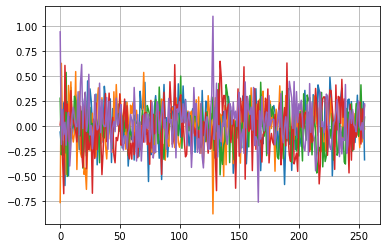

In [68]:
for i in exLatent[:5]:
    plt.plot(i)
plt.grid()
plt.show()

# Use NFLib

In [69]:
normsSampled = []

In [764]:
nfFolderPath = '/home/matthias/ETH/Thesis/nFlows/nflows/output'
exp_name = 'feasible-fire-18'
nfPath = os.path.join(nfFolderPath,exp_name)
flowArray = [] 
i=0
while(True):
    filename = os.path.join(nfPath, exp_name+str(i)+'.ckpt')
    i+=1
    if(os.path.isfile(filename)):
        file = np.load(filename)
        flowArray.append(file)
    else:
        break

In [ ]:
def loadDicts(dicts):
    modelArray = []
    for i in dicts:
        model = 

In [880]:
nfFolderPath = '/home/matthias/ETH/Thesis/nFlows/nflows'
nfCKPT = 'spring-plant-8.ckpt'
nfCKPT = 'divine-universe-10.ckpt' 
filename = 'fallen-cosmos-12'
filename = 'dainty-thunder-13'
filename = 'denim-voice-15'

nfFolderPath = '/home/matthias/ETH/Thesis/nFlows/nflows/output'
exp_name = 'feasible-fire-18'
exp_name = 'flowing-fire-19'
exp_name = 'silver-totem-20'
exp_name = 'crimson-bird-21'
exp_name = 'solar-yogurt-28'
nfPath = os.path.join(nfFolderPath,exp_name)
cepoch = 1
nfPath = os.path.join(nfPath, exp_name+str(cepoch)+'.ckpt')

## load Nf
flowDicts = torch.load(nfPath)
print(flowDicts.keys())
config = flowDicts['config']
print(config.keys())
nlayers = config['num_layers']
hiddenFeatures = config['hidden_features']
latentDim = 256
prior = MultivariateNormal(torch.zeros(latentDim), torch.eye(latentDim))

#prior = TransformedDistribution(Uniform(torch.zeros(latentDim), torch.ones(latentDim)), SigmoidTransform().inv) # Logistic distribution
flows = [AffineHalfFlow(dim=latentDim, parity=i%2, nh=hiddenFeatures) for i in range(nlayers)]
#norms = [ActNorm(dim=latentDim) for _ in flows]
#flows = list(itertools.chain(*zip(norms, flows)))

# flows = [Invertible1x1Conv(dim=latentDim) for i in range(nlayers)]
# norms = [ActNorm(dim=latentDim) for _ in flows]
# couplings = [AffineHalfFlow(dim=latentDim, parity=i%2, nh=hiddenFeatures) for i in range(len(flows))]
# flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1
    
    
model = NormalizingFlowModel(prior, flows)
model.load_state_dict(flowDicts['model_state_dict'])
print('Epoch: ',flowDicts['epoch'])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'config'])
dict_keys(['model', 'num_features', 'hidden_features', 'num_layers', 'lr'])
Epoch:  1


torch.Size([10, 256])


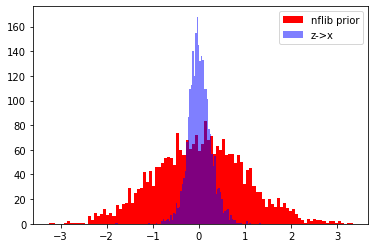

Mean nflib prior: 2.71552764E-02
Std nflib prior: 9.80944932E-01
Norm nflib prior: 1.57671604E+01
Mean nflib z->x: 1.32374838E-02
Std nflib z->x: 2.48181254E-01
Norm nflib z->x: 3.98751020E+00


In [881]:
model.eval()

p = model.prior.sample([10])#.squeeze()
print(p.shape)
new, logdet = model.backward(p)
fnew = new[-1].detach().numpy()
plt.hist(p.detach().numpy().flatten(),color='r',bins=100, alpha=1,label='nflib prior')
plt.hist(fnew.flatten(),bins=100,alpha=0.5, color='b', label = 'z->x')
plt.legend()
plt.show()

printGParams(p.detach().numpy(),'nflib prior')
printGParams(fnew,'nflib z->x')

In [902]:
noise = np.random.normal(0,0.01,(128))
print(noise)
print(noise.shape)

tensor([[ 0.0068, -0.0091,  0.0108,  ...,  0.0040, -0.0208, -0.0018],
        [-0.0134,  0.0086,  0.0117,  ..., -0.0040,  0.0011,  0.0064],
        [ 0.0074,  0.0105, -0.0079,  ..., -0.0086,  0.0079,  0.0123],
        ...,
        [-0.0033,  0.0177, -0.0130,  ...,  0.0148,  0.0039, -0.0204],
        [-0.0101,  0.0049,  0.0268,  ..., -0.0300,  0.0076, -0.0026],
        [ 0.0169,  0.0029,  0.0041,  ..., -0.0089, -0.0069,  0.0101]])
torch.Size([10, 256])


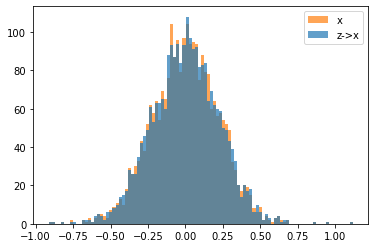

Mean Sampled: 1.90407725E-03
Std Sampled: 2.65343606E-01
Norm Sampled: 4.25050306E+00
Mean Groundtruth: 1.06094403E-05
Std Groundtruth: 2.21906468E-01
Norm Groundtruth: 3.57291746E+00


In [916]:
zs = model.sample(10)
z = zs[-1]
zf = z.detach().numpy()
z = zf.flatten()
#plt.hist(z, color='r',alpha=1,bins=100, label='z->x')
plt.hist([z,exLatent.flatten()], bins=100, alpha=0.7,label=['z->x','x'], stacked=False, histtype='stepfilled')
#plt.hist([(exLatent+noise.numpy()).flatten(),exLatent.flatten()], bins=100, alpha=0.7,label=['z->x','x'], stacked=False, histtype='stepfilled')
plt.legend()
plt.show()

printGParams(zf,'Sampled')
printGParams(exLatent,'Groundtruth')

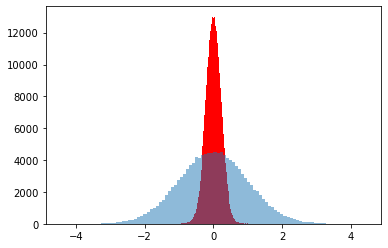

Mean latent: -5.036508810007945e-05
Mean flow sample: -0.002183054108172655
Std latent: 0.2255675345659256
Std flow sample: 0.9969854354858398


In [883]:
import matplotlib.pyplot as plt
l = latent[:1000].detach().cpu().numpy().flatten()
flow.eval()
f = flow._transform(flow.sample(1000))[0].detach().numpy().flatten()
plt.hist(l,color='r',bins=100)
plt.hist(f,bins=100,alpha=0.5)
plt.show()
print('Mean latent:', l.mean().astype('float'))
print('Mean flow sample:',f.mean().astype('float'))
print('Std latent:',l.std().astype('float'))
print('Std flow sample:',f.std().astype('float'))

(100, 256)
tensor(1.)
Generator Latent:  tensor(2.4333)
NF Latent sampled tensor(3.9258)


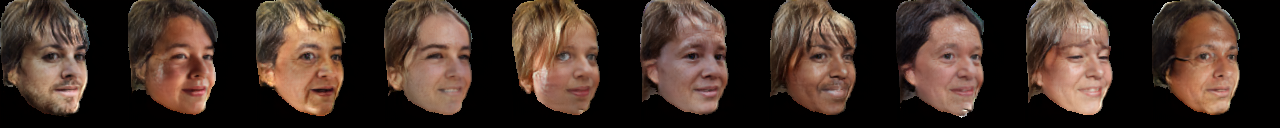

In [893]:
zs = model.sample(100)
z = zs[-1]
z = z.detach().numpy()
print(z.shape)
z = z.flatten()

shapes, expressions = demo.load_shape_expressions()
index_id, index_sp, index_ep = 184, 184, 184
sp = shapes[index_sp].unsqueeze(0)
ep = expressions[index_ep].unsqueeze(0)
theta = torch.Tensor((0,-35,0))
samples1 = flow.sample(10)
samples2 = flow.sample(10)
z_sampled = (normalizeT(torch.randn(10, 256),dim=1)*1)
samples =samples1/6
#samples = normalizeT(samples,dim=1)*3

z_sampled = (normalizeT(torch.randn(10, 256),dim=1)*1)
print(torch.norm(z_sampled,dim=1).mean())
print('Generator Latent: ',torch.norm(samples,dim=1).mean().detach())
samples = zs[-1].detach()
normsSampled.append(torch.norm(samples,dim=1).mean().item())
print('NF Latent sampled', torch.norm(samples,dim=1).mean())
norm = 0
batches_out = [demo.runGlo(z=z.unsqueeze(0), sp=sp, ep=ep, theta=theta) for z in samples[:10]]
demo.to_image(batches_out)

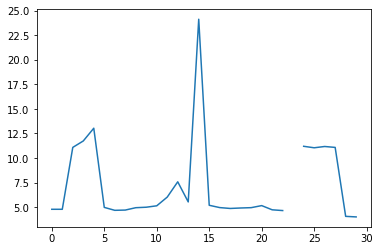

In [885]:
plt.plot(normsSampled)

In [790]:
print(normsSampled)

[4.783998966217041, 4.784063816070557, 11.079144477844238, 11.733219146728516, 13.02942180633545, 4.976813793182373, 4.678820610046387, 4.7041335105896, 4.944808483123779, 4.994322299957275, 5.138033390045166, 6.023771286010742, 7.578621864318848, 5.532463550567627, 24.113134384155273, 5.191282272338867]


# Non GLO demo

In [496]:
index_id, index_sp, index_ep = 184, 184, 184

shapes, expressions = demo.load_shape_expressions()
sp = shapes[index_sp].unsqueeze(0)
ep = expressions[index_ep].unsqueeze(0)

z = latent_mean[index_id].unsqueeze(0)
theta = torch.Tensor((0,-35,0))

batch_out = demo.run(z=z, sp=sp, ep=ep, theta=theta)
demo.to_image(batch_out)

NameError: name 'latent_mean' is not defined

Running multiple expressions...

In [ ]:
ep_indices = list(range(5))
batches_out = [demo.run(z=z, sp=sp, ep=expressions[ep_index].unsqueeze(0), theta=theta) for ep_index in ep_indices]
demo.to_image(batches_out)

### Pose
Pose can be defined as euler axes (degrees) `theta=(pitch, yaw, roll)`. 

* pitch > 0 $\rightarrow$ looking up
* yaw > 0 $\rightarrow$ looking left
* roll > 0 $\rightarrow$ rotate clockwise

In [ ]:
theta = torch.Tensor((-15, -20, 0))

batch_out = demo.run(z=z, sp=sp, ep=ep, theta=theta)
demo.to_image(batch_out)

In [ ]:
theta_all = [torch.Tensor((0, -t, 0)) for t in 
             np.arange(0, 46, 15)]

batches_out = [demo.run(z=z, sp=sp, ep=ep, theta=t) for t in theta_all]
demo.to_image(batches_out)

## Neural Control: Identity

### Sampling
VariTex controls identity via a latent code `z`. You can generate variants of this identity by resampling the latent code. Execute the cell below multiple times to see different outcomes.

You can change the variable `multiplier` to sample in more/less extreme regions of the learned distribution.

In [ ]:
index = 184
multiplier = 1.5
n_samples = 5
z_list = torch.distributions.Normal(latent_mean[index].clone(), latent_std[index].clone() * multiplier).rsample((n_samples,)) 
theta = torch.Tensor((0, 0, 0))

batches_out = [demo.run(z=z_l.unsqueeze(0), sp=sp, ep=ep, theta=theta) for z_l in z_list]
demo.to_image(batches_out)

### Interpolation
Interpolation between two latent codes smoothly transitions from one identity to another.

In [ ]:
from mutil.np_util import interpolation
n_samples = 5
indexA, indexB = 313, 184

zA, zB = latent_mean[indexA], latent_mean[indexB]
z_interpolated = torch.Tensor(interpolation(n_samples, zA.numpy(), zB.numpy()))

batches_out = [demo.run(z=z.unsqueeze(0), sp=sp, ep=ep, theta=theta) for z in z_interpolated]
demo.to_image(batches_out)

In [116]:
z = latent[:3]
print(z.shape)
z0, z1 = z[:,::2], z[:,1::2]
print(z0.shape)
print(z1.shape)

torch.Size([3, 256])
torch.Size([3, 128])
torch.Size([3, 128])
